<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 01 - Multi-layer Perceptron (MLP)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 1 – REDE MLP

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:

  * Diferentes topologias (>=5 topologias, variar número de
camadas

  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  
  * Avaliar o impacto do uso do Momentum

  * Avaliar o impacto do uso da regularização (i.e. L2)
  
  * [EXTRA] Avaliar o impacto do Dropout

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math
import pandas as pd
import time # for time mesurment

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

print(tf.__version__)

2.8.2


In [8]:
print(np.__version__)

1.21.6


# Regression

## Dataset

This dataset refers to the PSD of the two-point correlation function of the Cosmic Background Radiation and is of great importance for the determination of the cosmological parameters.

This data set can be found at 
http://pla.esac.esa.int/pla/#cosmology



In [2]:
!wget "http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt"

--2022-07-13 15:48:46--  http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/x-binary]
Saving to: ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’

product-action?COSM     [    <=>             ] 166.55K   153KB/s    in 1.1s    

2022-07-13 15:48:48 (153 KB/s) - ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’ saved [170547]



In [3]:
df = pd.read_fwf('product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt')
df.columns = ["id","l", "Dl", "+dDl", "-dDl"]
df.drop('id', axis=1, inplace=True)

In [4]:
#Normalize data
#https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
df.l =  (df.l - df.l.mean()) / df.l.std()
df.Dl =  (df.Dl - df.Dl.mean()) / df.Dl.std()
df['+dDl'] =  (df['+dDl'] - df['+dDl'].mean()) / df['+dDl'].std()
df['+dDl'] =  (df['-dDl'] - df['-dDl'].mean()) / df['-dDl'].std()

$$ D_l = \frac{l(l+1)Cl}{(2\pi)} $$

[]

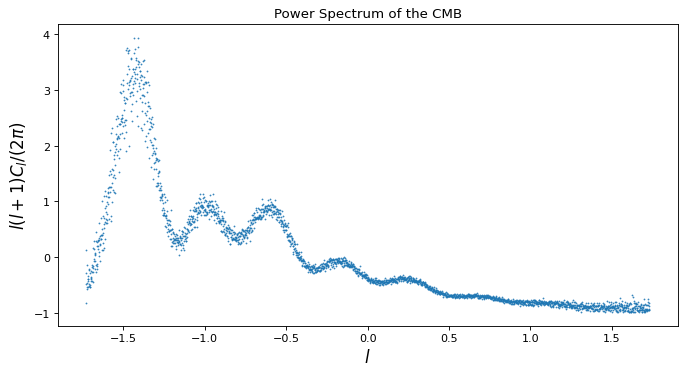

In [5]:
#from IPython.core.pylabtools import figsize
figure(figsize=(10,5),dpi=80)
plt.scatter(df.l,df.Dl,s=0.3)
#plt.errorbar(l, Dl, df.min_error, df.max_error, fmt='r^')
#plt.xscale('log')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.title("Power Spectrum of the CMB")
plt.plot()


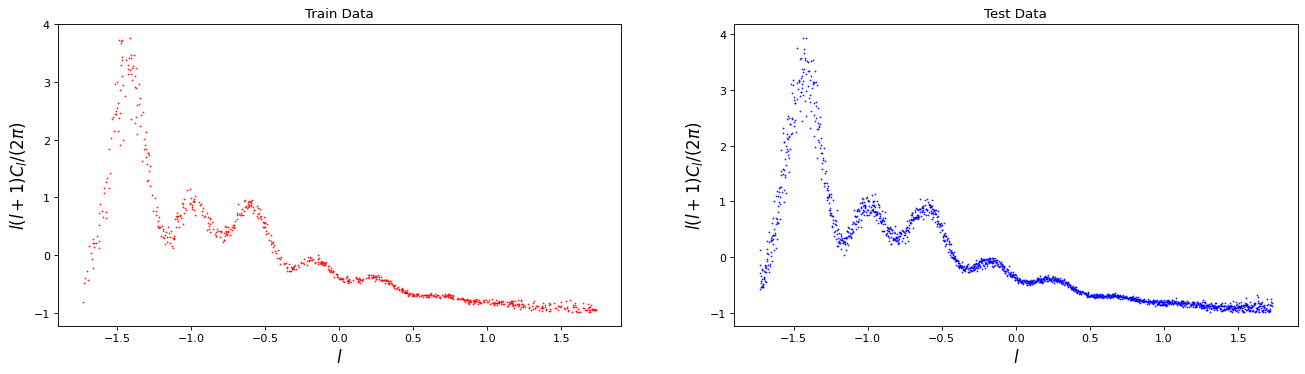

In [6]:
# Spliting in traing and Validation 
x_train, x_test, y_train, y_test = train_test_split(df.l, df.Dl, test_size=0.7)
# print(len(x_train))
# print(len(x_test))
figure(figsize=(20,5),dpi=80)

plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='red',s=0.3)
plt.title('Train Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
#plt.xscale('log')

plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='blue',s=0.3)
plt.title('Test Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
#plt.xscale('log')
plt.show()


## Comun parametes

In [7]:
#Paramentes
adam = tf.keras.optimizers.Adam()

## Topology 1

To attempt to build a network capable of finding a regression law for these problems, we will generate 5 different network topologies. The first will be the simple and classic case of a perceptron and the second will increase the number of layers and the number of neurons.

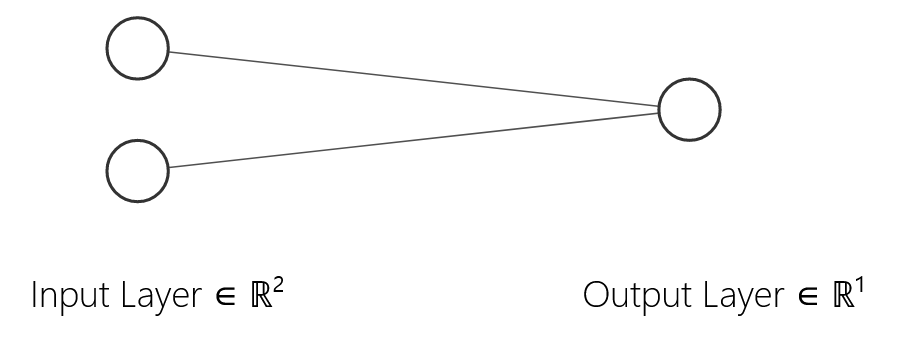

In [15]:
#Model_11 -- Dropout null and moment null
fl2   = 0.0
drop  = 0.0
momen = 0.0
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_11= keras.Sequential()
model_11.add(keras.layers.Dense(units=3,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_11.add(Dropout(drop))
model_11.add(keras.layers.Dense(units=1,kernel_regularizer=l2(fl2), activation="linear"))
model_11.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])
#tf.keras.utils.plot_model(model_01, show_shapes=True)

#Model_12 -- Regularization 0.2; Dropout 0.0; Momentum 0.0
fl2   = 0.2
drop  = 0.0
momen = 0.0
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_12= keras.Sequential()
model_12.add(keras.layers.Dense(units=3,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_12.add(Dropout(drop))
model_12.add(keras.layers.Dense(units=1,kernel_regularizer=l2(fl2), activation="linear"))
model_12.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_13 -- Regularization 0.0; Dropout 0.2; Momentum 0.0
fl2   = 0.0
drop  = 0.2
momen = 0.0
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_13= keras.Sequential()
model_13.add(keras.layers.Dense(units=3,kernel_regularizer=l2(fl2), input_shape=[1], activation="relu"))
model_13.add(Dropout(drop))
model_13.add(keras.layers.Dense(units=1,kernel_regularizer=l2(fl2), activation="linear"))
model_13.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_14 -- Regularization 0.0; Dropout 0.0; Momentum 0.2
fl2   = 0.0
drop  = 0.0
momen = 0.2
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_14= keras.Sequential()
model_14.add(keras.layers.Dense(units=3,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_14.add(Dropout(drop))
model_14.add(keras.layers.Dense(units=1,kernel_regularizer=l2(fl2), activation="linear"))
model_14.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_15-- Regularization 0.2; Dropout 0.0; Momentum 0.2
fl2   = 0.2
drop  = 0.0
momen = 0.2
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_15= keras.Sequential()
model_15.add(keras.layers.Dense(units=3,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_15.add(Dropout(drop))
model_15.add(keras.layers.Dense(units=1,kernel_regularizer=l2(fl2), activation="linear"))
model_15.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


#Model_16 -- Regularization 0.2; Dropout 0.2; Momentum 0.2
fl2   = 0.2
drop  = 0.2
momen = 0.2
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_16= keras.Sequential()
model_16.add(keras.layers.Dense(units=3,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_16.add(Dropout(drop))
model_16.add(keras.layers.Dense(units=1,kernel_regularizer=l2(fl2), activation="linear"))
model_16.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

# #Model_x - Supose to be the last and more powerfull model
# model_x = keras.Sequential()
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="sigmoid"))
# model_x.add(keras.layers.Dense(units=50, activation="linear"))

### Treining Topology 1

In [18]:
#O que é isso?
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

#Traing Model_11
start_time_11 = time.time()
history_11 = model_11.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_11 = time.time()

#Traing Model_12
start_time_12 = time.time()
history_12 = model_12.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_12 = time.time()

#Traing Model_13
start_time_13 = time.time()
history_13 = model_13.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_13 = time.time()

#Traing Model_14
start_time_14 = time.time()
history_14 = model_14.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_14 = time.time()

#Traing Model_14
start_time_15 = time.time()
history_15 = model_14.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_15 = time.time()

#Traing Model_14
start_time_16 = time.time()
history_16 = model_14.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_16 = time.time()

# #Traing Model_01
# start_time_x = time.time()
# history_x = model_x.fit(x_train, y_train, epochs=3000, batch_size=10, validation_split=0.2, verbose=1)#, 
# end_time_x = time.time()
# # print("Network parameters: {}".format(model.get_weights()))



A saída de streaming foi truncada nas últimas 5000 linhas.
61/61 [==============================] - 1s 5ms/step - loss: 2.5581 - mean_absolute_error: 1.2243 - val_loss: 1.6841 - val_mean_absolute_error: 0.9609
Epoch 2/500
61/61 [==============================] - 0s 2ms/step - loss: 1.5418 - mean_absolute_error: 0.9190 - val_loss: 1.2692 - val_mean_absolute_error: 0.8084
Epoch 3/500
61/61 [==============================] - 0s 3ms/step - loss: 1.2261 - mean_absolute_error: 0.7960 - val_loss: 1.0657 - val_mean_absolute_error: 0.7210
Epoch 4/500
61/61 [==============================] - 0s 3ms/step - loss: 1.0476 - mean_absolute_error: 0.7052 - val_loss: 0.9390 - val_mean_absolute_error: 0.6489
Epoch 5/500
61/61 [==============================] - 0s 3ms/step - loss: 0.9253 - mean_absolute_error: 0.6364 - val_loss: 0.8516 - val_mean_absolute_error: 0.5918
Epoch 6/500
61/61 [==============================] - 0s 4ms/step - loss: 0.8429 - mean_absolute_error: 0.5759 - val_loss: 0.7936 - val_mea

In [20]:
print((end_time_11 - start_time_11)/60,'minutos')
print((end_time_12 - start_time_12)/60,'minutos')
print((end_time_13 - start_time_13)/60,'minutos')
print((end_time_14 - start_time_14)/60,'minutos')
print((end_time_15 - start_time_15)/60,'minutos')
print((end_time_16 - start_time_16)/60,'minutos')


print((end_time_16 - start_time_11)/60,'minutos')

2.377794138590495 minutos
1.4933137893676758 minutos
1.6686285614967347 minutos
2.0792784094810486 minutos
2.2906790733337403 minutos
3.366637428601583 minutos
13.276335060596466 minutos


### Results Topology 1

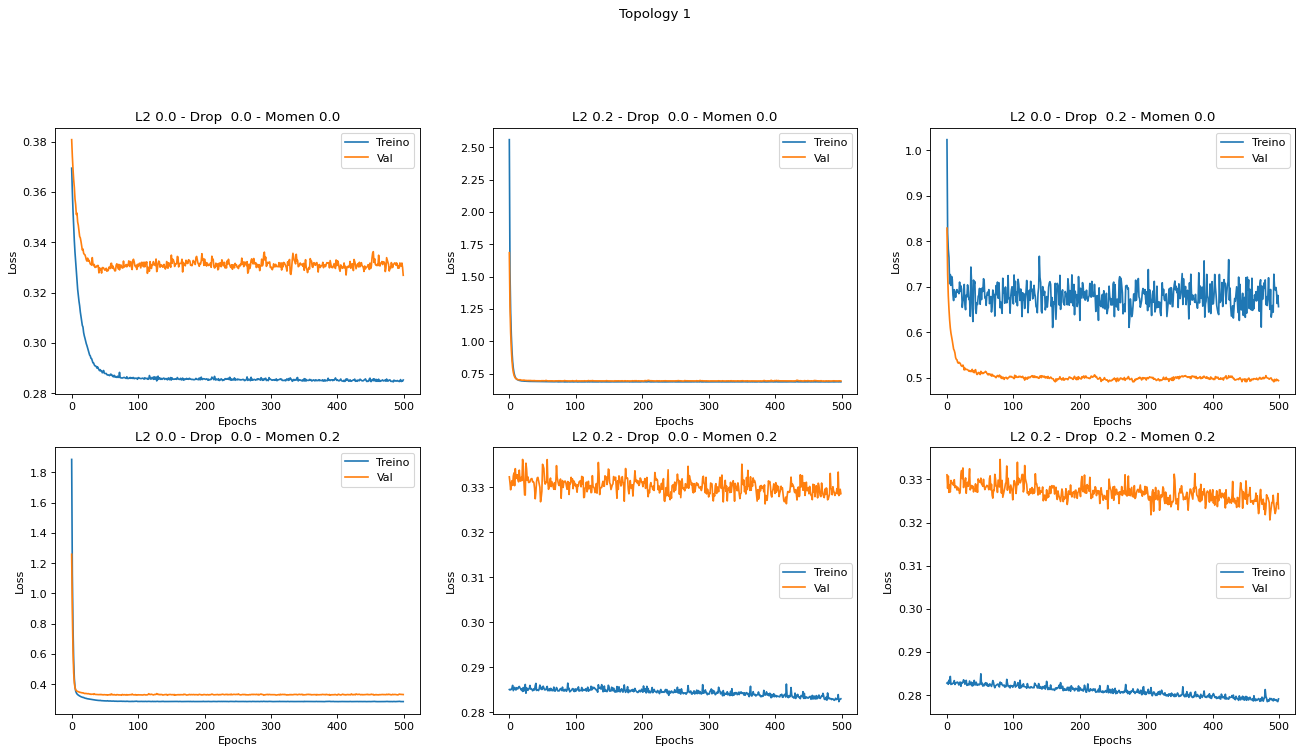

In [23]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("Topology 1")
plt.subplot(3,3,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_11.history['loss'], label="Treino")
plt.plot(history_11.history['val_loss'], label="Val")
plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
plt.legend()

plt.subplot(3,3,2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_12.history['loss'], label="Treino")
plt.plot(history_12.history['val_loss'], label="Val")
plt.title('L2 0.2 - Drop  0.0 - Momen 0.0')
plt.legend()

plt.subplot(3,3,3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_13.history['loss'], label="Treino")
plt.plot(history_13.history['val_loss'], label="Val")
plt.title('L2 0.0 - Drop  0.2 - Momen 0.0')
plt.legend()

plt.subplot(3,3,4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_14.history['loss'], label="Treino")
plt.plot(history_14.history['val_loss'], label="Val")
plt.title('L2 0.0 - Drop  0.0 - Momen 0.2')
plt.legend()

plt.subplot(3,3,5)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_15.history['loss'], label="Treino")
plt.plot(history_15.history['val_loss'], label="Val")
plt.title('L2 0.2 - Drop  0.0 - Momen 0.2')
plt.legend()

plt.subplot(3,3,6)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_16.history['loss'], label="Treino")
plt.plot(history_16.history['val_loss'], label="Val")
plt.title('L2 0.2 - Drop  0.2 - Momen 0.2')
plt.legend()

plt.show()

### Avaliation Topology 1

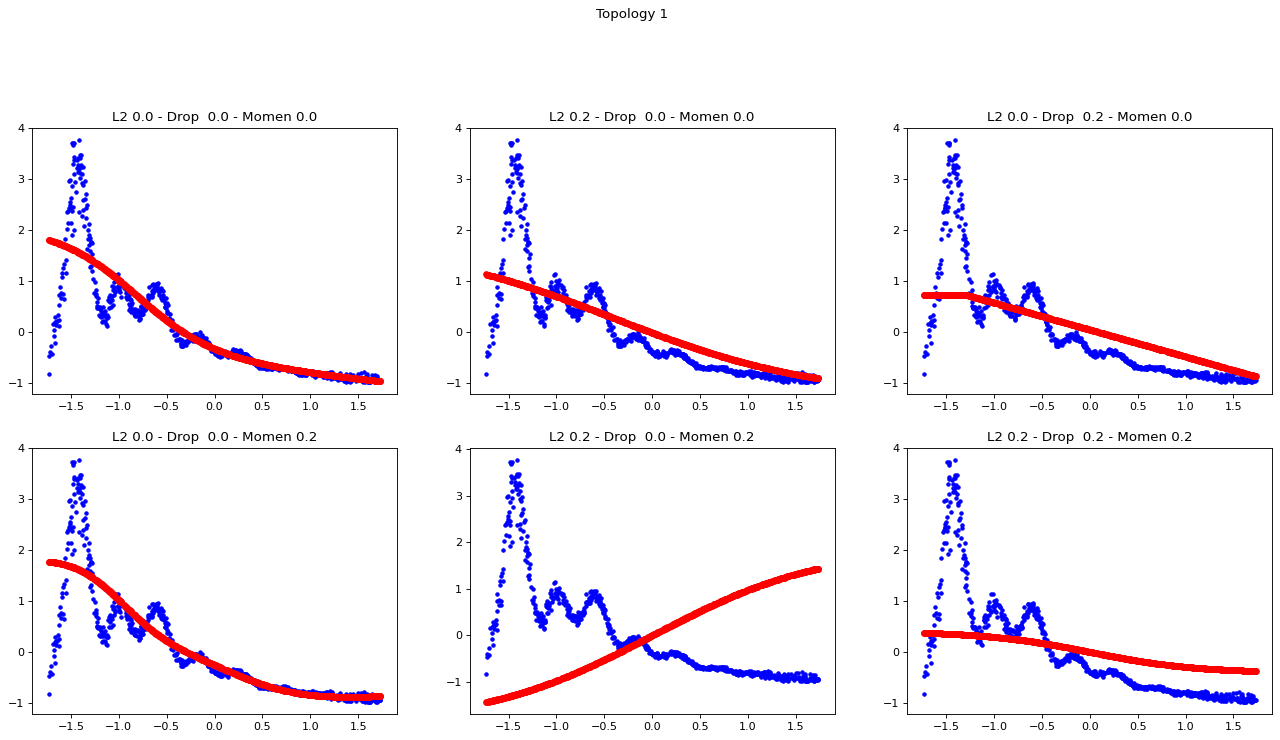

In [25]:
figure(figsize=(20,15),dpi=80)
plt.suptitle('Topology 1')

plt.subplot(         3,3,1)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_11.predict(x_train), '.', markersize=10 ,color='red')
plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

plt.subplot(         3,3,2)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_12.predict(x_train), '.', markersize=10 ,color='red')
plt.title('L2 0.2 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

plt.subplot(        3,3,3)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_13.predict(x_train), '.', markersize=10 ,color='red')
plt.title('L2 0.0 - Drop  0.2 - Momen 0.0')
#plt.xscale('log')

plt.subplot(        3,3,4)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_14.predict(x_train), '.', markersize=10 ,color='red')
plt.title('L2 0.0 - Drop  0.0 - Momen 0.2')

plt.subplot(        3,3,5)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_15.predict(x_train), '.', markersize=10 ,color='red')
plt.title('L2 0.2 - Drop  0.0 - Momen 0.2')

plt.subplot(        3,3,6)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_16.predict(x_train), '.', markersize=10 ,color='red')
plt.title('L2 0.2 - Drop  0.2 - Momen 0.2')


#plt.xscale('log')
plt.show()

In [30]:
score_11 = model_11.evaluate(x_test, y_test, verbose=0)
score_12 = model_12.evaluate(x_test, y_test, verbose=0)
score_13 = model_13.evaluate(x_test, y_test, verbose=0)
score_14 = model_14.evaluate(x_test, y_test, verbose=0)
score_15 = model_15.evaluate(x_test, y_test, verbose=0)
score_16 = model_16.evaluate(x_test, y_test, verbose=0)


print(               "Model 11")
print("Test loss:",   score_11[0])
print("Test metric:", score_11[1],'\n')
print(               "Model 12")
print("Test loss:",   score_12[0])
print("Test metric:", score_12[1],'\n')
print(               "Model 13")
print("Test loss:",   score_13[0])
print("Test metric:", score_13[1],'\n')
print(               "Model 14")
print("Test loss:",   score_14[0])
print("Test metric:", score_14[1],'\n')
print(               "Model 15")
print("Test loss:",   score_15[0])
print("Test metric:", score_15[1],'\n')
print(               "Model 16")
print("Test loss:",   score_16[0])
print("Test metric:", score_16[1],'\n')
  

Model 11
Test loss: 0.2971556782722473
Test metric: 0.2807336449623108 

Model 12
Test loss: 0.6352046728134155
Test metric: 0.3678639531135559 

Model 13
Test loss: 0.41575172543525696
Test metric: 0.43225446343421936 

Model 14
Test loss: 0.29189765453338623
Test metric: 0.28146958351135254 

Model 15
Test loss: 4.09498405456543
Test metric: 1.5338813066482544 

Model 16
Test loss: 1.3241113424301147
Test metric: 0.5606529712677002 



## Topology 2 

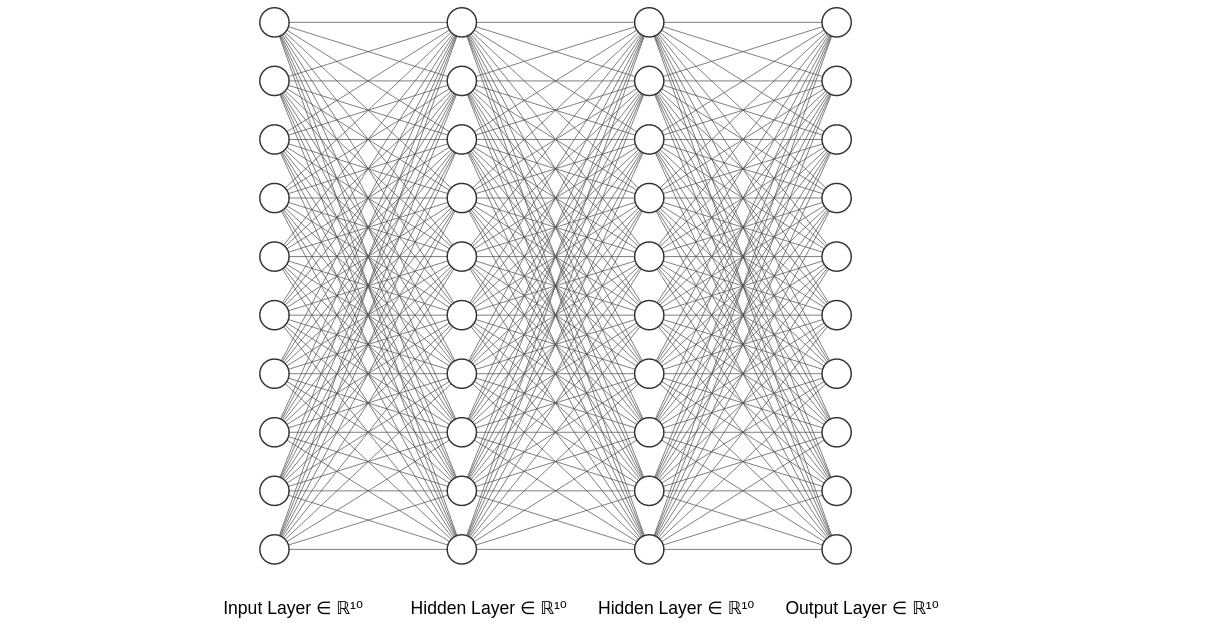

In [32]:
#Model_11 -- Dropout null and moment null
fl2   = 0.0
drop  = 0.0
momen = 0.0
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_21= keras.Sequential()
model_21.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_21.add(Dropout(drop))
model_21.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_21.add(Dropout(drop))
model_21.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_21.add(Dropout(drop))
model_21.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_21.add(Dropout(drop))
model_21.add(keras.layers.Dense(units=1, activation="linear"))
model_21.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_12 -- Regularization 0.2; Dropout 0.0; Momentum 0.0
fl2   = 0.2
drop  = 0.0
momen = 0.0
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_22= keras.Sequential()
model_22.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_22.add(Dropout(drop))
model_22.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_22.add(Dropout(drop))
model_22.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_22.add(Dropout(drop))
model_22.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_22.add(Dropout(drop))
model_22.add(keras.layers.Dense(units=1, activation="linear"))
model_22.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_13 -- Regularization 0.0; Dropout 0.2; Momentum 0.0
fl2   = 0.0
drop  = 0.2
momen = 0.0
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_23= keras.Sequential()
model_23.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_23.add(Dropout(drop))
model_23.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_23.add(Dropout(drop))
model_23.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_23.add(Dropout(drop))
model_23.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_23.add(Dropout(drop))
model_23.add(keras.layers.Dense(units=1, activation="linear"))
model_23.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_14 -- Regularization 0.0; Dropout 0.0; Momentum 0.2
fl2   = 0.0
drop  = 0.0
momen = 0.2
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_24= keras.Sequential()
model_24.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_24.add(Dropout(drop))
model_24.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_24.add(Dropout(drop))
model_24.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_24.add(Dropout(drop))
model_24.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_24.add(Dropout(drop))
model_24.add(keras.layers.Dense(units=1, activation="linear"))
model_24.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_15-- Regularization 0.2; Dropout 0.0; Momentum 0.2
fl2   = 0.2
drop  = 0.0
momen = 0.2
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_25= keras.Sequential()
model_25.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_25.add(Dropout(drop))
model_25.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_25.add(Dropout(drop))
model_25.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_25.add(Dropout(drop))
model_25.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_25.add(Dropout(drop))
model_25.add(keras.layers.Dense(units=1, activation="linear"))
model_25.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


#Model_16 -- Regularization 0.2; Dropout 0.2; Momentum 0.2
fl2   = 0.2
drop  = 0.2
momen = 0.2
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momen)

model_26= keras.Sequential()
model_26.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_26.add(Dropout(drop))
model_26.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_26.add(Dropout(drop))
model_26.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_26.add(Dropout(drop))
model_26.add(keras.layers.Dense(units=10,kernel_regularizer=l2(fl2), activation="linear"))
model_26.add(Dropout(drop))
model_26.add(keras.layers.Dense(units=1, activation="linear"))
model_26.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

# #Model_x - Supose to be the last and more powerfull model
# model_x = keras.Sequential()
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(Dropout(drop))
# model_x.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
# model_x.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="sigmoid"))
# model_x.add(keras.layers.Dense(units=50, activation="linear"))

### Treining Topology 2



In [33]:
#O que é isso?
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

#Traing Model_11
start_time_21 = time.time()
history_21 = model_11.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_21 = time.time()

#Traing Model_12
start_time_22 = time.time()
history_22 = model_12.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_22 = time.time()

#Traing Model_13
start_time_23 = time.time()
history_23 = model_13.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_23 = time.time()

#Traing Model_14
start_time_24 = time.time()
history_24 = model_14.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_24 = time.time()

#Traing Model_14
start_time_25 = time.time()
history_25 = model_14.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_25 = time.time()

#Traing Model_14
start_time_26 = time.time()
history_26 = model_14.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_26 = time.time()


A saída de streaming foi truncada nas últimas 5000 linhas.
61/61 [==============================] - 0s 3ms/step - loss: 0.6860 - mean_absolute_error: 0.3827 - val_loss: 0.6930 - val_mean_absolute_error: 0.4139
Epoch 2/500
61/61 [==============================] - 0s 2ms/step - loss: 0.6857 - mean_absolute_error: 0.3845 - val_loss: 0.6932 - val_mean_absolute_error: 0.4154
Epoch 3/500
61/61 [==============================] - 0s 3ms/step - loss: 0.6859 - mean_absolute_error: 0.3819 - val_loss: 0.6943 - val_mean_absolute_error: 0.4159
Epoch 4/500
61/61 [==============================] - 0s 3ms/step - loss: 0.6857 - mean_absolute_error: 0.3820 - val_loss: 0.6928 - val_mean_absolute_error: 0.4151
Epoch 5/500
61/61 [==============================] - 0s 3ms/step - loss: 0.6855 - mean_absolute_error: 0.3836 - val_loss: 0.6937 - val_mean_absolute_error: 0.4165
Epoch 6/500
61/61 [==============================] - 0s 3ms/step - loss: 0.6865 - mean_absolute_error: 0.3839 - val_loss: 0.6932 - val_mea

In [36]:
print((end_time_21 - start_time_21)/60,'minutos')
print((end_time_22 - start_time_22)/60,'minutos')
print((end_time_23 - start_time_23)/60,'minutos')
print((end_time_24 - start_time_24)/60,'minutos')
print((end_time_25 - start_time_25)/60,'minutos')
print((end_time_26 - start_time_26)/60,'minutos')


print((end_time_26 - start_time_21)/60,'minutos')

2.366160968939463 minutos
2.366188657283783 minutos
2.3661144812901815 minutos
2.366338348388672 minutos
2.3660668889681498 minutos
2.366344769795736 minutos
14.197216963768005 minutos


### Results Topology 2


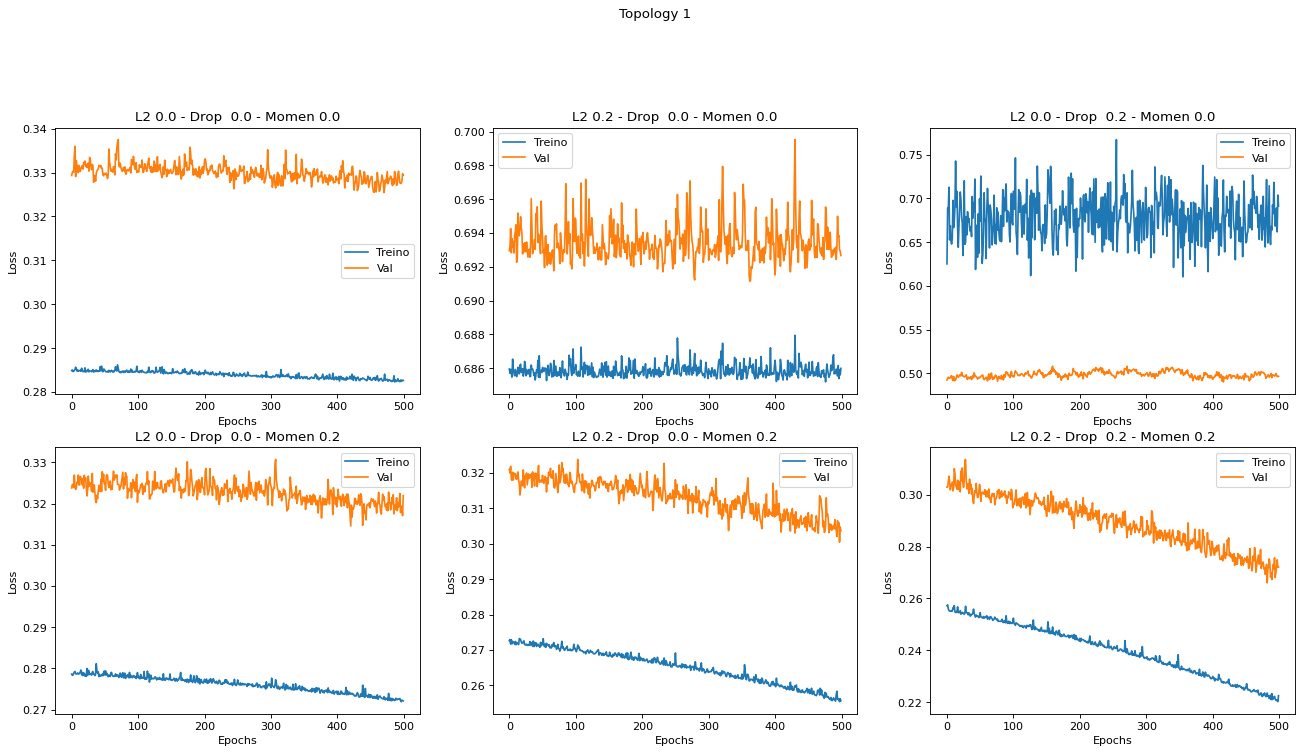

In [37]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("Topology 1")
plt.subplot(3,3,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_21.history['loss'], label="Treino")
plt.plot(history_21.history['val_loss'], label="Val")
plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
plt.legend()

plt.subplot(3,3,2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_22.history['loss'], label="Treino")
plt.plot(history_22.history['val_loss'], label="Val")
plt.title('L2 0.2 - Drop  0.0 - Momen 0.0')
plt.legend()

plt.subplot(3,3,3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_23.history['loss'], label="Treino")
plt.plot(history_23.history['val_loss'], label="Val")
plt.title('L2 0.0 - Drop  0.2 - Momen 0.0')
plt.legend()

plt.subplot(3,3,4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_24.history['loss'], label="Treino")
plt.plot(history_24.history['val_loss'], label="Val")
plt.title('L2 0.0 - Drop  0.0 - Momen 0.2')
plt.legend()

plt.subplot(3,3,5)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_25.history['loss'], label="Treino")
plt.plot(history_25.history['val_loss'], label="Val")
plt.title('L2 0.2 - Drop  0.0 - Momen 0.2')
plt.legend()

plt.subplot(3,3,6)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_26.history['loss'], label="Treino")
plt.plot(history_26.history['val_loss'], label="Val")
plt.title('L2 0.2 - Drop  0.2 - Momen 0.2')
plt.legend()

plt.show()

### Avaliation Topology 2

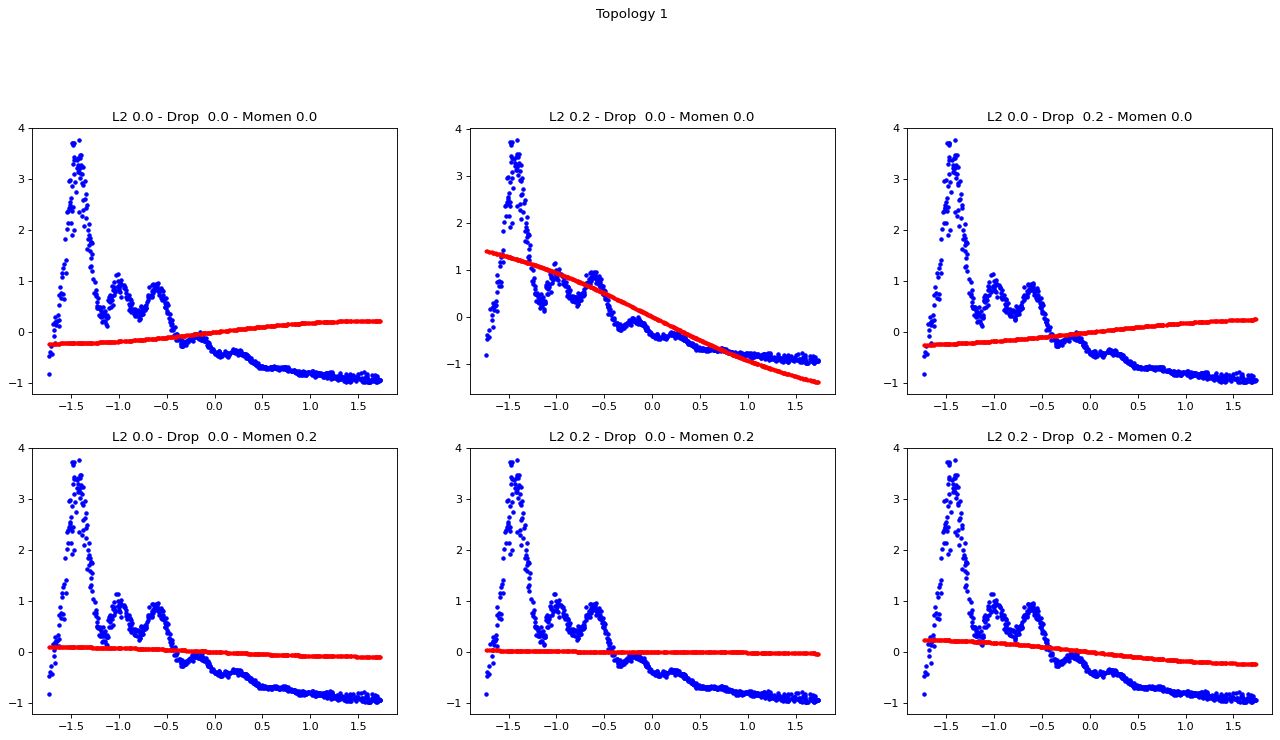

In [39]:
figure(figsize=(20,15),dpi=80)
plt.suptitle('Topology 1')

plt.subplot(         3,3,1)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_21.predict(x_train), '.', markersize=5 ,color='red')
plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

plt.subplot(         3,3,2)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_22.predict(x_train), '.', markersize=5 ,color='red')
plt.title('L2 0.2 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

plt.subplot(        3,3,3)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_23.predict(x_train), '.', markersize=5 ,color='red')
plt.title('L2 0.0 - Drop  0.2 - Momen 0.0')
#plt.xscale('log')

plt.subplot(        3,3,4)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_24.predict(x_train), '.', markersize=5 ,color='red')
plt.title('L2 0.0 - Drop  0.0 - Momen 0.2')

plt.subplot(        3,3,5)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_25.predict(x_train), '.', markersize=5 ,color='red')
plt.title('L2 0.2 - Drop  0.0 - Momen 0.2')

plt.subplot(        3,3,6)
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x_train, model_26.predict(x_train), '.', markersize=5 ,color='red')
plt.title('L2 0.2 - Drop  0.2 - Momen 0.2')


#plt.xscale('log')
plt.show()

### Topology 3 

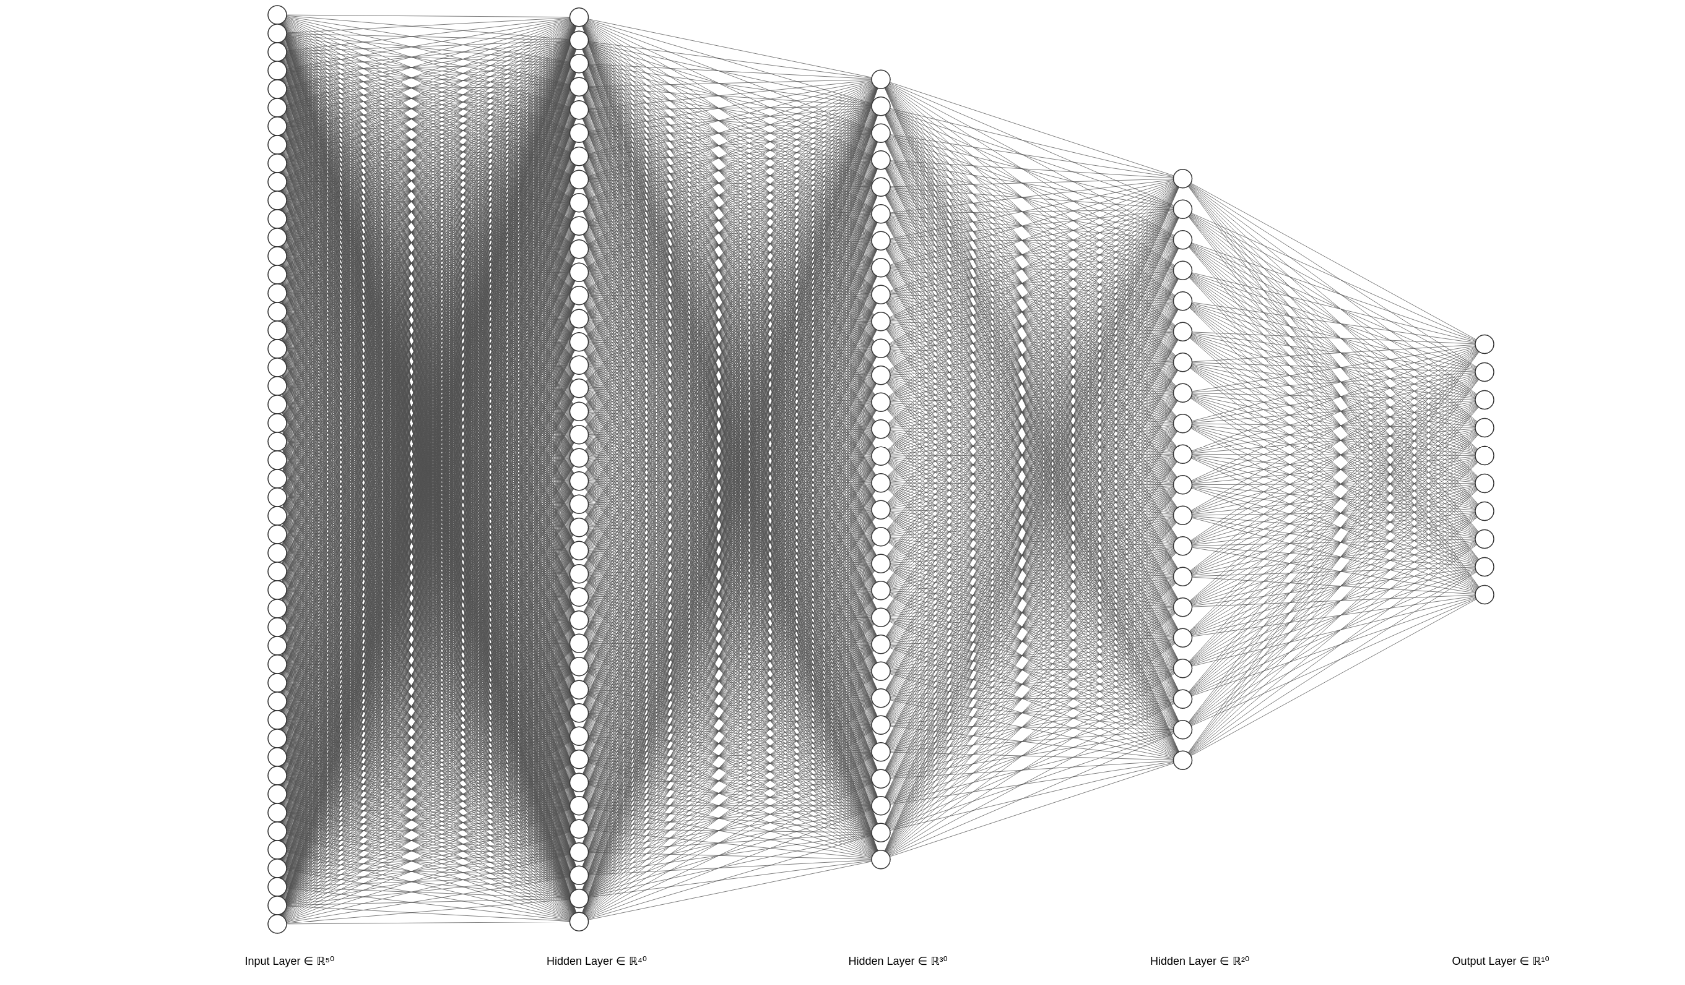